In [10]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [11]:
from subprocess import check_output

In [12]:
dataset = pd.read_csv('Sentiment.csv', encoding='latin-1')

In [13]:
dataset = dataset[['text','sentiment']]

In [14]:
dataset.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

In [20]:
train_pos.dtypes

dtype('O')

Positive words


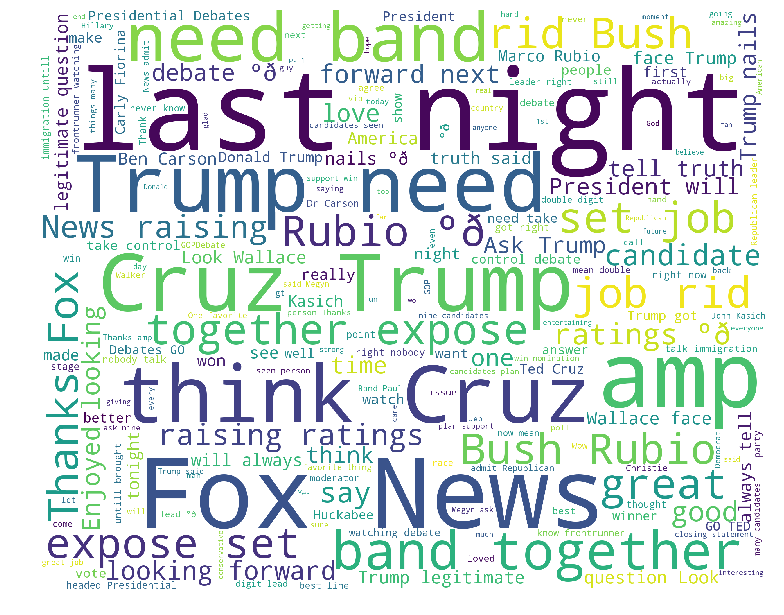

Negative words


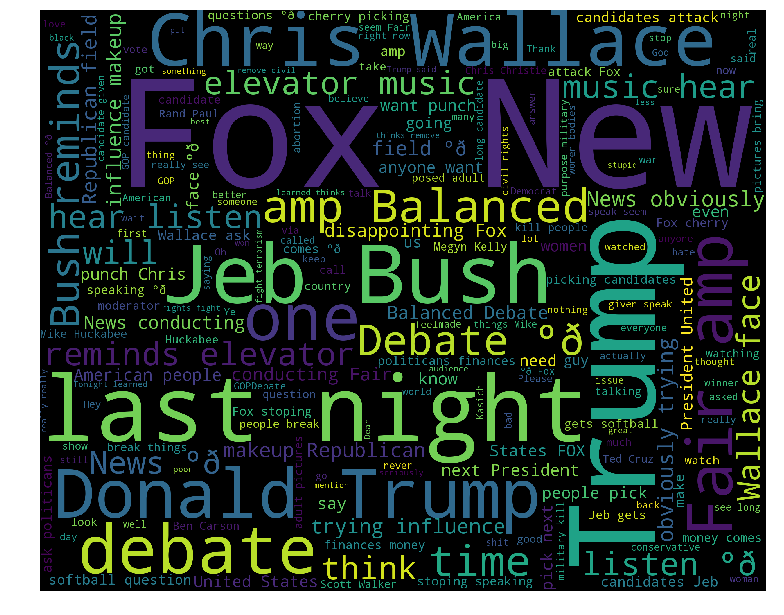

In [16]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [8]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [9]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

In [10]:
w_features

dict_keys(['why', 'should', 'pledge', 'support', 'the', 'gop', 'when', 'establishment', 'sold', 'out', 'obama?', 'ð\x9f\x87ºð\x9f\x87¸', 'disheartening', 'row', 'ten', 'tall', 'men...', "where's", 'ainslie', 'hayes', 'you', 'need', 'her?', '"the', 'purpose', 'military', 'kill', 'people', 'and', 'break', 'things"-mike', 'huckabee', 'jim', 'gilmore', 'clueless', "it's", 'not', 'state?', 'they', 'already', 'rule', 'area', 'larger', 'than', 'united', 'kingdom.', 'this', 'happened:', 'single', 'mention', 'tonightâ\x80\x99s', 'presume', 'megyn', 'kelly', 'spent', 'all', 'night', 'rolling', 'her', 'eyes', 'make', 'for', 'times', 'she', "couldn't", 'during', 'think', 'cruz', 'trump', 'band', 'together', 'expose', 'set', 'job,', 'get', 'rid', 'bush', 'rubio,', 'donates', 'u..he', 'can', 'call', 'favor', 'years', 'later??', 'sounds', 'like', 'thats', 'legal?', 'jeb', 'reminds', 'elevator', 'music.', 'hear', 'but', "don't", 'listen.', '1st', 'place', 'fiorina.', '2nd', 'jindal.', 'fox', 'news', "

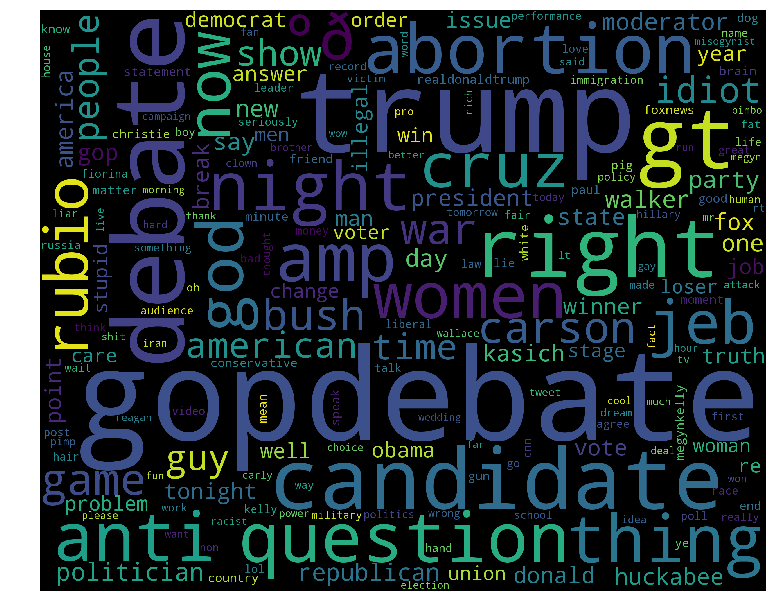

In [22]:
wordcloud_draw(w_features)

In [11]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [24]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 832/778 
[Positive]: 218/97 


In [21]:
from sklearn.feature_extraction import DictVectorizer

In [22]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [41]:
tweets = []
import string
ponctuation = ['?','!','%','&']
numbers = ['0','1','2','3','4','5','6','7','8','9']
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split()]
#     words_filtered = [word.replace(i,'') for word in words_filtered]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'rt']
    tweets.append(words_cleaned)

In [42]:
distinc_list = []
for sub_listas in tweets:
    for palavras in sub_listas:
        if palavras not in distinc_list:
            distinc_list.append(palavras)

In [43]:
distinc_list

['why',
 'should',
 'pledge',
 'support',
 'to',
 'the',
 'gop',
 'when',
 'establishment',
 'sold',
 'out',
 'obama?',
 'ð\x9f\x87ºð\x9f\x87¸',
 'disheartening',
 'row',
 'of',
 'ten',
 'tall',
 'men...',
 "where's",
 'ainslie',
 'hayes',
 'you',
 'need',
 'her?',
 '"the',
 'purpose',
 'military',
 'is',
 'kill',
 'people',
 'and',
 'break',
 'things"-mike',
 'huckabee',
 'jim',
 'gilmore',
 'clueless',
 'on',
 "it's",
 'not',
 'a',
 'state?',
 'they',
 'already',
 'rule',
 'an',
 'area',
 'larger',
 'than',
 'united',
 'kingdom.',
 'this',
 'happened:',
 'single',
 'mention',
 'in',
 'tonightâ\x80\x99s',
 'i',
 'presume',
 'megyn',
 'kelly',
 'spent',
 'all',
 'night',
 'rolling',
 'her',
 'eyes',
 'make',
 'up',
 'for',
 'times',
 'she',
 "couldn't",
 'during',
 'think',
 'cruz',
 'trump',
 'band',
 'together',
 'expose',
 'set',
 'job,',
 'get',
 'rid',
 'bush',
 'rubio,',
 'if',
 'donates',
 'u..he',
 'can',
 'call',
 'favor',
 'years',
 'later??',
 'sounds',
 'like',
 'thats',
 '